In [54]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import pytz
import numpy as np
import os

In [55]:
#open CO2 files, extract relevant columns, normalize column names
co2_burned_2022 = pd.read_csv('Burned_Pond_CO2_062422-081622.csv')[['TIMESTAMP','CO2_High_ppm','CO2_High_RA_ppm','WaterTemp_degC']]
co2_burned_2022['pond'] = 'burned'
co2_burned_2022['co2_depth'] = 1.0
co2_burned_2022['temp_depth'] = 1.0

co2_burned_2023 = pd.read_excel('Dissolved_CO2_15BPond_070723-091123.xlsx')[['TIMESTAMP','CO2_High_ppm','CO2_High_RA_ppm','Water_Temp_degC']]
co2_burned_2023 = co2_burned_2023.rename(columns={'Water_Temp_degC':'WaterTemp_degC'})
co2_burned_2023['pond'] = 'burned'

co2_burned_2024 = pd.read_excel('Dissolved_CO2_15BPond_070724-090824.xlsx')[['TIMESTAMP','CO2_High','CO2_High_RA']]
co2_burned_2024 = co2_burned_2024.rename(columns={'CO2_High':'CO2_High_ppm', 'CO2_High_RA':'CO2_High_RA_ppm'})
co2_burned_2024['pond'] = 'burned'
co2_burned_2024['WaterTemp_degC'] = np.nan

co2_unburned_2022 = pd.read_csv('UB_Pond_CO2_062622-072822.csv')[['Date','CO2_High_ppm','CO2_High_RA_ppm','WaterTemp_degC']]
co2_unburned_2022['pond'] = 'unburned'
co2_unburned_2022 = co2_unburned_2022.rename(columns={'Date':'TIMESTAMP'})

co2_unburned_2023 = pd.read_excel('Dissolved_CO2_UBPond_070223-091123.xlsx')[['Timestamp','CO2_High_ppm','CO2_High_RA_ppm','Water_Temp_degC']]
co2_unburned_2023 = co2_unburned_2023.rename(columns={'Timestamp': 'TIMESTAMP', 'Water_Temp_degC':'WaterTemp_degC'})
co2_unburned_2023['pond'] = 'unburned'

co2_unburned_2024 = pd.read_excel('Dissolved_CO2_UBPond_071524-090824.xlsx')[['TIMESTAMP','CO2_High','CO2_High_RA']]
co2_unburned_2024 = co2_unburned_2024.rename(columns={'CO2_High':'CO2_High_ppm', 'CO2_High_RA':'CO2_High_RA_ppm'})
co2_unburned_2024['pond'] = 'unburned'
co2_unburned_2024['WaterTemp_degC'] = np.nan

#merge all co2 files
co2_all = pd.concat([co2_burned_2022, co2_burned_2023, co2_burned_2024, 
                     co2_unburned_2022, co2_unburned_2023, co2_unburned_2024])
co2_all['TIMESTAMP'] = pd.to_datetime(co2_all['TIMESTAMP'])

co2_all_daily = co2_all.groupby(by=['pond',co2_all['TIMESTAMP'].dt.date]).aggregate({
                                                                                      'CO2_High_ppm':['mean', 'std'],
                                                                                      'WaterTemp_degC':['mean', 'std']
                                                                                        })
co2_all_daily.columns = ["_".join(a) for a in co2_all_daily.columns.to_flat_index()]
co2_all_daily = co2_all_daily.reset_index()
co2_all_daily['co2_depth'] = 1.0
co2_all_daily['temp_depth'] = 1.0
co2_all_daily.head(5)

,pond,TIMESTAMP,CO2_High_ppm_mean,CO2_High_ppm_std,WaterTemp_degC_mean,WaterTemp_degC_std,co2_depth,temp_depth
0,burned,2022-06-24,1268.185481,641.426389,NaN,NaN,1.0,1.0
1,burned,2022-06-25,1183.261600,136.955860,NaN,NaN,1.0,1.0
2,burned,2022-06-26,874.438129,120.871066,NaN,NaN,1.0,1.0
3,burned,2022-06-27,841.687394,49.184830,NaN,NaN,1.0,1.0
4,burned,2022-06-28,999.626102,89.336912,NaN,NaN,1.0,1.0


In [56]:
#open 2024 temperature files
july_dir = '../temperature/Collected_202407'
sept_dir = '../temperature/Collected_202409'

In [57]:
files=[os.path.join(july_dir, f) for f in os.listdir(july_dir)]+[os.path.join(sept_dir, f) for f in os.listdir(sept_dir)]
temp_2024=[]
for file in files:
    
    df=pd.read_csv(file, parse_dates=['Date-Time (AKDT)'])
    df = df[['Date-Time (AKDT)', 'WaterTemp_degC']].rename(columns={'Date-Time (AKDT)': 'TIMESTAMP'})
    df['chamber'] = int(file.split(' ')[1])
    temp_2024.append(df)
temp_2024=pd.concat(temp_2024)

#AKDT to AKST
temp_2024['TIMESTAMP'] = temp_2024['TIMESTAMP'].dt.tz_localize(pytz.timezone('Etc/GMT+8'))
temp_2024['TIMESTAMP'] = temp_2024['TIMESTAMP'].dt.tz_convert(pytz.timezone('Etc/GMT+9'))
temp_2024['pond'] = 'unburned'
temp_2024.loc[temp_2024['chamber']<=3, 'pond'] = 'burned'

In [58]:
temp_2024_daily = temp_2024.groupby(by=['chamber',temp_2024['TIMESTAMP'].dt.date]).aggregate({
                                                                                      'WaterTemp_degC':['mean', 'std']
                                                                                        })
temp_2024_daily.columns = ["_".join(a) for a in temp_2024_daily.columns.to_flat_index()]
temp_2024_daily = temp_2024_daily.reset_index()
temp_2024_daily['pond'] = 'unburned'
temp_2024_daily.loc[temp_2024_daily['chamber']<=3, 'pond'] = 'burned'
temp_2024_daily.head()

,chamber,TIMESTAMP,WaterTemp_degC_mean,WaterTemp_degC_std,pond
0,1,2024-07-03,15.417785,0.848757,burned
1,1,2024-07-04,13.082141,0.497284,burned
2,1,2024-07-05,13.388893,0.843733,burned
3,1,2024-07-06,12.512972,0.409649,burned
4,1,2024-07-07,13.730064,2.154364,burned


<Axes: xlabel='TIMESTAMP', ylabel='WaterTemp_degC_mean'>

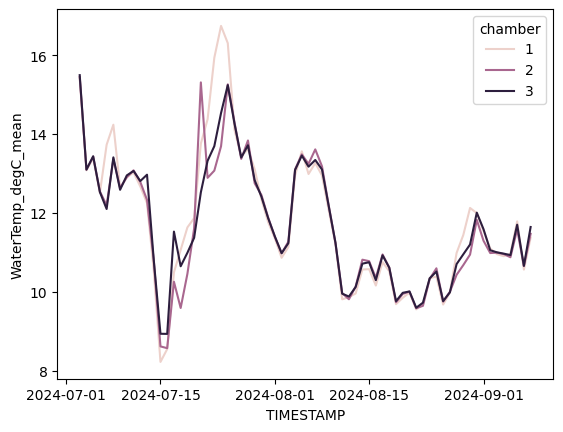

In [59]:
sns.lineplot(temp_2024_daily.loc[temp_2024_daily['pond']=='burned'],
             x='TIMESTAMP', y='WaterTemp_degC_mean', hue='chamber')


In [60]:
#daily mean and std temperature for burned and unburned ponds, 2024
temp_2024_daily_mean = temp_2024.groupby(by=['pond',temp_2024['TIMESTAMP'].dt.date]).aggregate({
                                                                                      'WaterTemp_degC':['mean', 'std']
                                                                                        })
temp_2024_daily_mean.columns = ["_".join(a) for a in temp_2024_daily_mean.columns.to_flat_index()]
temp_2024_daily_mean = temp_2024_daily_mean.reset_index()

temp_2024_daily_mean.head(5)

,pond,TIMESTAMP,WaterTemp_degC_mean,WaterTemp_degC_std
0,burned,2024-07-03,15.453616,0.830278
1,burned,2024-07-04,13.093383,0.500491
2,burned,2024-07-05,13.418579,0.856207
3,burned,2024-07-06,12.529478,0.407699
4,burned,2024-07-07,12.674640,1.466938


In [61]:
#merge 2024 temp data into rest of data
co2_all_daily = co2_all_daily.merge(temp_2024_daily_mean, 
                                    on=['pond', 'TIMESTAMP'], 
                                    how='left', suffixes=['', '_t2024'])

co2_all_daily['WaterTemp_degC_mean'] = co2_all_daily['WaterTemp_degC_mean'].combine_first(co2_all_daily['WaterTemp_degC_mean_t2024'])
co2_all_daily['WaterTemp_degC_std'] = co2_all_daily['WaterTemp_degC_std'].combine_first(co2_all_daily['WaterTemp_degC_std_t2024'])
co2_all_daily = co2_all_daily.drop(columns = ['WaterTemp_degC_mean_t2024', 'WaterTemp_degC_std_t2024'])

In [62]:
def Vant_Hoff(T):
    #calculates Henry's law coefficient for CO2 at given temperature
    KHstar = 29
    kT_CO2 = 2400
    T_star = 298.15
    KH = KHstar * np.exp(kT_CO2*((1 / T) - (1 / T_star)))

    return KH
    
def ppm_to_molarity_co2(co2_ppm, T, sensor_depth=1, mean_air_pres = 100986, temp_input = 'C'):
    #for co2 sensor measurements
    p_hydrostatic = 1000 * 9.8 * sensor_depth #Pa
    co2_ppm_corr = co2_ppm * (mean_air_pres/(mean_air_pres+p_hydrostatic))

    pCO2 = co2_ppm_corr * (mean_air_pres+p_hydrostatic) * 1e-6
    
    if temp_input=='C':
        T = T+273.15
        
    KH = Vant_Hoff(T) * 101325

    MCO2 = (pCO2 / KH) #mol CO2 / L solution

    #MCO2 = MCO2 * 1000 #mol / m3
    
    return MCO2 * 1e6 #umol/L

In [63]:
co2_all_daily['CO2_umol_L'] = ppm_to_molarity_co2(co2_all_daily['CO2_High_ppm_mean'], co2_all_daily['WaterTemp_degC_mean'])
co2_all_daily['CO2_umol_L_std'] = ppm_to_molarity_co2(co2_all_daily['CO2_High_ppm_std'], co2_all_daily['WaterTemp_degC_std'])
co2_all_daily

,pond,TIMESTAMP,CO2_High_ppm_mean,CO2_High_ppm_std,WaterTemp_degC_mean,WaterTemp_degC_std,co2_depth,temp_depth,CO2_umol_L,CO2_umol_L_std
0,burned,2022-06-24,1268.185481,641.426389,NaN,NaN,1.0,1.0,NaN,NaN
1,burned,2022-06-25,1183.261600,136.955860,NaN,NaN,1.0,1.0,NaN,NaN
2,burned,2022-06-26,874.438129,120.871066,NaN,NaN,1.0,1.0,NaN,NaN
3,burned,2022-06-27,841.687394,49.184830,NaN,NaN,1.0,1.0,NaN,NaN
4,burned,2022-06-28,999.626102,89.336912,NaN,NaN,1.0,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
342,unburned,2024-09-04,15536.200833,363.629404,11.236898,0.305869,1.0,1.0,361.663096,6.041029
343,unburned,2024-09-05,15100.307917,535.196418,11.806944,0.643012,1.0,1.0,357.500850,8.987908
344,unburned,2024-09-06,15492.217500,588.666748,12.303171,0.480642,1.0,1.0,372.188940,9.834583
345,unburned,2024-09-07,15935.917083,480.660736,10.945486,0.368505,1.0,1.0,367.770542,8.001353


In [64]:
co2_all_daily = co2_all_daily.rename(columns={'TIMESTAMP': 'datetime', 
                                              'CO2_High_ppm_mean': 'CO2_meas_ppm_mean',
                                              'CO2_High_ppm_std': 'CO2_meas_ppm_std',  
                                              'WaterTemp_degC_mean': 'WaterTemp_meas_degC_mean',
                                              'WaterTemp_degC_std': 'WaterTemp_meas_degC_std'})

In [65]:
co2_all_daily.columns

Index(['pond', 'datetime', 'CO2_meas_ppm_mean', 'CO2_meas_ppm_std',
       'WaterTemp_meas_degC_mean', 'WaterTemp_meas_degC_std', 'co2_depth',
       'temp_depth', 'CO2_umol_L', 'CO2_umol_L_std'],
      dtype='object')

In [66]:
co2_all_daily['datetime'] = pd.to_datetime(co2_all_daily['datetime'])
co2_all_daily['year'] = co2_all_daily['datetime'].dt.year

In [67]:
co2_all_daily.to_csv('CO2_all.csv', index=False)

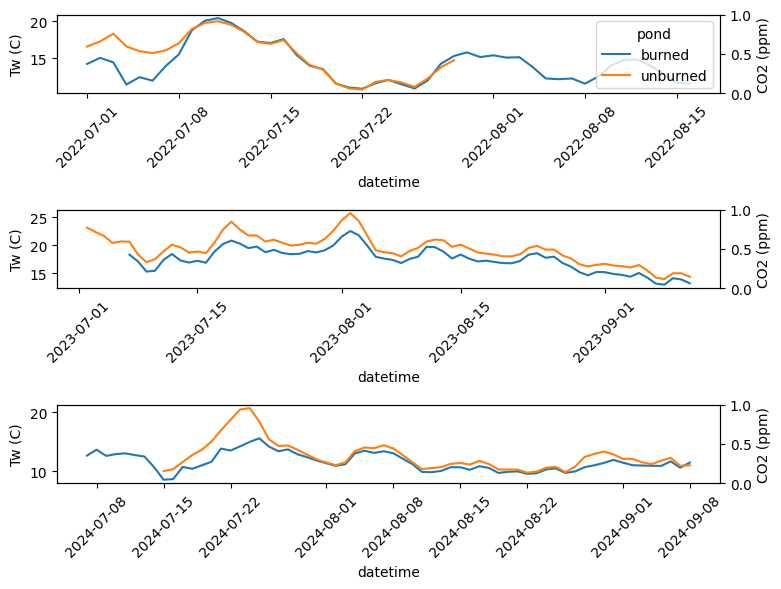

In [131]:
fig, axes = plt.subplots(len(co2_all_daily['year'].unique()),1, figsize=(8,6))
for i, year in enumerate(co2_all_daily['year'].unique()):
    data=co2_all_daily.loc[co2_all_daily['year']==year]
    sns.lineplot(data=data, x='datetime', y='WaterTemp_meas_degC_mean', ax=axes[i], hue='pond')
    ax_sec = axes[i].twinx()
    #sns.lineplot(data=data, x='datetime', y='CO2_meas_ppm_mean', ax=ax_sec, hue='pond', linestyle='--')

    if i!=0:
        axes[i].get_legend().remove()
    #ax_sec.get_legend().remove()
    axes[i].set_ylabel('Tw (C)')
    ax_sec.set_ylabel('CO2 (ppm)')
    axes[i].tick_params(axis='x', labelrotation=45)
fig.tight_layout()



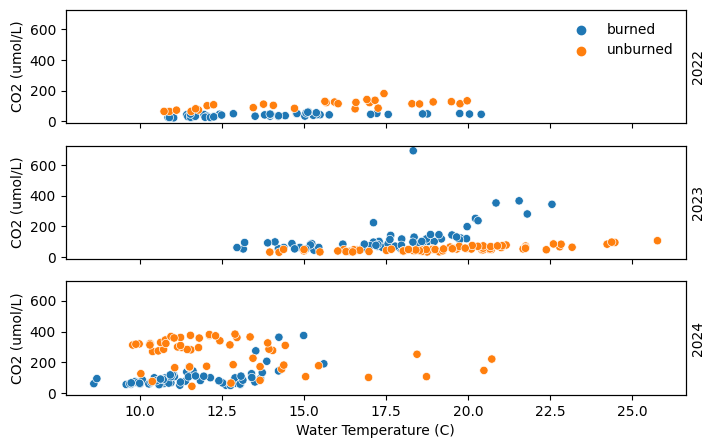

In [69]:
fig, axes=plt.subplots(3,1, figsize=(8,5), sharex=True, sharey=True)

for i, year in enumerate(co2_all_daily['year'].unique()):

    data=co2_all_daily.loc[co2_all_daily['year']==year]
    sns.scatterplot(data=data, x='WaterTemp_meas_degC_mean', y='CO2_umol_L', ax=axes[i], hue='pond')
    ax_sec = axes[i].twinx()
    ax_sec.set_yticks([])
    axes[i].legend(frameon=False, title='')
    if i!=0:
        axes[i].get_legend().remove()

    ax_sec.set_ylabel(year)
    axes[i].set_ylabel('CO2 (umol/L)')
    axes[2].set_xlabel('Water Temperature (C)')

In [108]:
path_to_met_data = '../../LAKE/ponds_2019-2024/YKD-burned.dat'
met_data = pd.read_csv(path_to_met_data)
met_data['datetime'] = pd.to_datetime(met_data[['Year', 'Month', 'Day']])
met_data['Temp'] = met_data['Temp'] - 273.15
met_data['doy'] = met_data['datetime'].dt.day_of_year
met_data['wind_speed'] = np.sqrt(np.power(met_data['Uspeed'],2)+np.power(met_data['Vspeed'],2))
met_data['precip_mm'] = met_data['Precip'] * 8.64e+7

co2_all_daily['doy'] = met_data['datetime'].dt.day_of_year

In [109]:
co2_all_daily_merged = co2_all_daily.merge(met_data, on=['datetime'], how='left').reset_index()
co2_all_daily_merged['doy'] = co2_all_daily_merged['datetime'].dt.day_of_year

/tmp/ipykernel_17524/3071881256.py:19: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


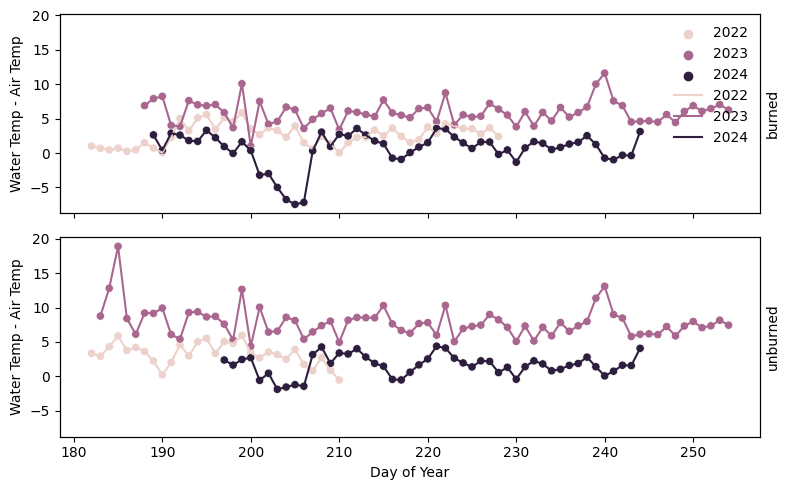

In [138]:
fig, axes=plt.subplots(2,1, figsize=(8,5), sharex=True, sharey=True)

for i, pond in enumerate(co2_all_daily_merged['pond'].unique()):

    data=co2_all_daily_merged.loc[co2_all_daily_merged['pond']==pond]

    sns.scatterplot(data=data, x='doy', y=data['WaterTemp_meas_degC_mean'] - data['Temp'], ax=axes[i], hue='year')
    sns.lineplot(data=data, x='doy', y=data['WaterTemp_meas_degC_mean'] - data['Temp'], ax=axes[i], hue='year')

    ax_sec = axes[i].twinx()
    ax_sec.set_yticks([])
    axes[i].legend(frameon=False, title='')
    if i!=0:
        axes[i].get_legend().remove()

    ax_sec.set_ylabel(pond)
    axes[i].set_ylabel('Water Temp - Air Temp')
    axes[1].set_xlabel('Day of Year')
    fig.tight_layout()
    plt.savefig('water_air_temp_diff.jpg', dpi=300)

/tmp/ipykernel_17524/3050673180.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sns.lineplot(data=met_data.loc[met_data['Year']>2021].groupby(by=['Year', 'Month']).mean().reset_index(),
/tmp/ipykernel_17524/3050673180.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sns.scatterplot(data=met_data.loc[met_data['Year']>2021].groupby(by=['Year', 'Month']).mean().reset_index(),


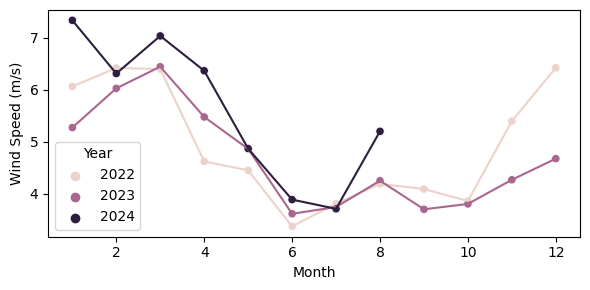

In [112]:
fig, ax = plt.subplots(figsize=(6,3))

sns.lineplot(data=met_data.loc[met_data['Year']>2021].groupby(by=['Year', 'Month']).mean().reset_index(), 
             x='Month', y='wind_speed', hue='Year', legend=False)

sns.scatterplot(data=met_data.loc[met_data['Year']>2021].groupby(by=['Year', 'Month']).mean().reset_index(), 
             x='Month', y='wind_speed', hue='Year')

ax.set_ylabel('Wind Speed (m/s)')
ax.set_xlabel('Month')

fig.tight_layout()

/tmp/ipykernel_17524/2971155003.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sns.lineplot(data=met_data.loc[met_data['Year']>2021].groupby(by=['Year', 'Month']).mean().reset_index(),
/tmp/ipykernel_17524/2971155003.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sns.scatterplot(data=met_data.loc[met_data['Year']>2021].groupby(by=['Year', 'Month']).mean().reset_index(),


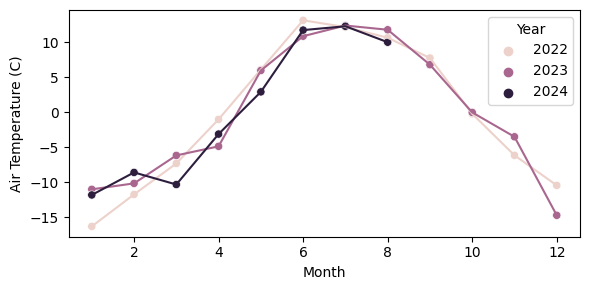

In [113]:
fig, ax = plt.subplots(figsize=(6,3))

sns.lineplot(data=met_data.loc[met_data['Year']>2021].groupby(by=['Year', 'Month']).mean().reset_index(), 
             x='Month', y='Temp', hue='Year', legend=False)

sns.scatterplot(data=met_data.loc[met_data['Year']>2021].groupby(by=['Year', 'Month']).mean().reset_index(), 
             x='Month', y='Temp', hue='Year')

ax.set_ylabel('Air Temperature (C)')
ax.set_xlabel('Month')

fig.tight_layout()

/tmp/ipykernel_17524/1376072578.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sns.lineplot(data=met_data.loc[met_data['Year']>2021].groupby(by=['Year', 'Month']).sum().reset_index(),
/tmp/ipykernel_17524/1376072578.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sns.scatterplot(data=met_data.loc[met_data['Year']>2021].groupby(by=['Year', 'Month']).sum().reset_index(),


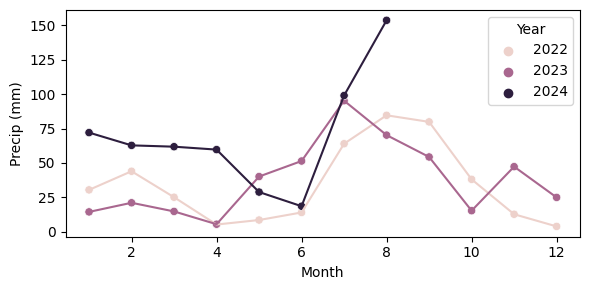

In [115]:
fig, ax = plt.subplots(figsize=(6,3))

sns.lineplot(data=met_data.loc[met_data['Year']>2021].groupby(by=['Year', 'Month']).sum().reset_index(), 
             x='Month', y='precip_mm', hue='Year', legend=False)

sns.scatterplot(data=met_data.loc[met_data['Year']>2021].groupby(by=['Year', 'Month']).sum().reset_index(), 
             x='Month', y='precip_mm', hue='Year')

ax.set_ylabel('Precip (mm)')
ax.set_xlabel('Month')

fig.tight_layout()

plt.savefig('monthly_precip_YKD.jpg', dpi=300)

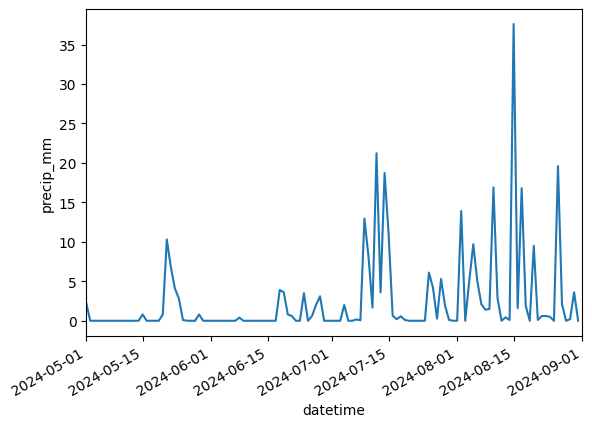

In [137]:
fig, ax = plt.subplots()

sns.lineplot(data = met_data, x='datetime', y='precip_mm')

ax.set_xlim(pd.to_datetime('2024-05-01'), pd.to_datetime('2024-09-01'))

fig.autofmt_xdate()